In [1]:
import copy
import random
import itertools


# Plotting candies
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# Number stuff.
import numpy as np
import pandas as pd

# Neural net things.
import torch
from torch import tensor
from torch.nn import Sequential, Linear, Sigmoid, L1Loss, ReLU, MSELoss
from torch.optim import Adam

torch.manual_seed(0)


def run_nn():
    X = tensor([[0.,0.], [0.,1.], [1.,0.], [1.,1.]])
    Y = tensor([[0,],[1.],[1.],[0.]])

    # Use tensor.shape to get in-/output dimension size.
    num_data, input_dim = X.shape
    num_data, output_dim = Y.shape

    # Set the hidden dimension.
    hidden_dim = 10
    # Set the learning rate.
    lr = 0.03
    # Define no. of epochs.
    epochs = 300

    # Define the model.
    model = Sequential(Linear(input_dim, hidden_dim),
                       ReLU(),
                       Linear(hidden_dim, output_dim),
                       Sigmoid())
    # Define the optimization criterion
    criterion = MSELoss()
    # Initialize the optimizer.
    optimizer = Adam(model.parameters(), lr=lr)

    # Training routine
    losses = []
    for _e in range(epochs):
        optimizer.zero_grad()
        pred = model(X)           # Fowards.
        loss = criterion(pred, Y) # Loss.
        loss.backward()           # Backprop.
        optimizer.step() # Update model params.
        losses.append(float(loss.data))
        
    return losses

In [2]:
import copy
import random
import itertools


# Plotting candies
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# Number stuff.
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch 
from torch import tensor
from torch.nn import Sequential, Linear, Sigmoid, MSELoss, ReLU
from torch.optim import Adam

def run_evo(kill_bad_babies=False):

    X = tensor([[0,0], [0,1], [1,0], [1,1]]).float()
    Y = tensor([[0],[1],[1],[0]]).float()

    # Use tensor.shape to get in-/output dimension size.
    num_data, input_dim = X.shape
    num_data, output_dim = Y.shape

    init_population_size = 20
    mutation_rate = 0.01
    generations = 300
    hidden_dim = 10


    def get_random_pairs(numbers):
        # Generate all possible non-repeating pairs
        pairs = list(itertools.combinations(numbers, 2))
        # Randomly shuffle these pairs
        random.shuffle(pairs)
        return pairs

    # Define the model.
    def create_model(lr):
        # Each network will be initialized as such.
        model = Sequential(Linear(input_dim, hidden_dim),
                          ReLU(),
                          Linear(hidden_dim, output_dim),
                          Sigmoid())
        return {'model': model, 
                'optim': Adam(model.parameters(), lr=lr),
                'generation': 0,
                'loss': None, 'g_loss': None
               }

    # Initialize the optimizer.
    lr =  0.03
    # Define the optimization criterion
    criterion = MSELoss()
    # We create 20 networks.
    population = 20
    fittest = [create_model(lr) for i in range(population)]
    survival_rate = 0.5
    mutation_rate = 0.1

    evo_losses = []


    for _g in tqdm(range(generations)):
        # Get through every network.
        for i, network in enumerate(fittest):
            network['optim'].zero_grad()
            pred = network['model'](X)            # Fowards.
            network['loss'] = criterion(pred, Y)  # Loss.

        # Only the fittest (i.e. lowest loss) survive 
        # at pre-defined survival rate.
        num_survivors = max(1, int(survival_rate*population))
        fittest = sorted(fittest, key=lambda n: n['loss'])[:num_survivors]

        # Populate the rest of the generation with offsprings of the fittest.
        for mating_pairs in get_random_pairs(fittest):

            if len(fittest) == population:
                break
            else:
                female, male = mating_pairs
                # Access female's model and optimizers 
                female_model = female['model']
                female_optim = female['optim'] 
                # Access male's model and optimizers 
                male_model = male['model']
                male_optim = male['optim']

                # Make an "empty" baby by copying first.
                baby_model = copy.deepcopy(female_model)
                baby_optim = copy.deepcopy(female_optim)

                for layer_name in zip(female_model.state_dict()):
                    ## Crossover process.
                    f = female_model.state_dict()[layer_name[0]]
                    m = male_model.state_dict()[layer_name[0]]
                    # Randomly generate a crossover point.
                    crossover_pt = int(random.uniform(0, f.shape[0]))
                    # Make baby with crossover tensors.
                    tmp =  copy.deepcopy(m[:crossover_pt])
                    m[:crossover_pt], f[:crossover_pt] = f[:crossover_pt], tmp
                    baby_layer =  random.choice([m, f])

                    ## Mutation process.
                    baby_layer = baby_layer * (1-mutation_rate)

                    # Overwrite the state_dict layers of the baby
                    baby_model.state_dict()[layer_name[0]] = baby_layer

                # Compute baby's loss.
                _pred = baby_model(X)
                _loss = criterion(_pred, Y) 

                fittest.append({'model': baby_model, 
                                'optim': baby_optim, 
                                'generation':_g, 
                                'loss':_loss, }
                               )
    

        current_loss = float('inf')
        # Back propagate for all models.
        for network in fittest: 
            network['loss'].backward(retain_graph=True)  # Backwards.
            network['optim'].step()     # Update weights.
            if network['loss'] < current_loss:
                current_loss = network['loss']


        if kill_bad_babies:
            if evo_losses and current_loss < evo_losses[-1]:
                # Kill all the babies.
                fittest = fittest[:num_survivors] 

        evo_losses.append(float(current_loss))         

    fittest = sorted(fittest, key=lambda n: n['loss'])
    #print(_g, [net['generation'] for net in fittest])
        
    return evo_losses, fittest

100%|██████████| 300/300 [00:05<00:00, 54.23it/s]


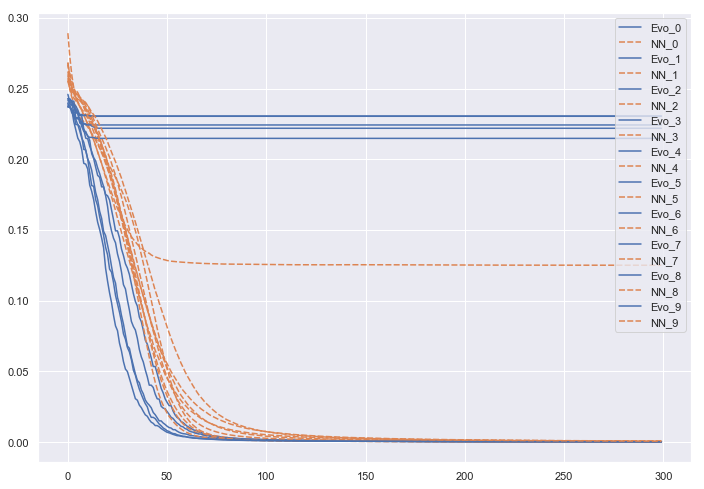

In [3]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

for i in range(10):
    losses = run_nn()
    evo_losses, fittest = run_evo()
    ##print([net['generation'] for net in fittest])
    ax = sns.lineplot(data=pd.DataFrame({f"Evo_{i}":pd.Series(evo_losses), 
                                         f"NN_{i}":pd.Series(losses)}))
    


100%|██████████| 300/300 [00:05<00:00, 53.78it/s]


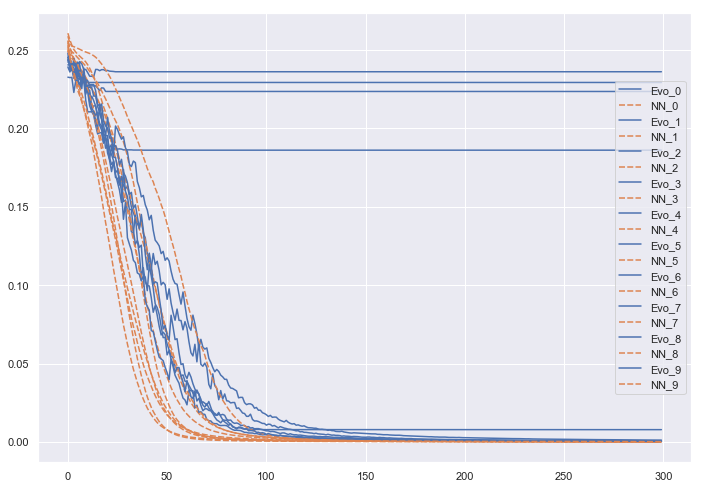

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

for i in range(10):
    losses = run_nn()
    evo_losses, fittest = run_evo(kill_bad_babies=True)
    ##print([net['generation'] for net in fittest])
    ax = sns.lineplot(data=pd.DataFrame({f"Evo_{i}":pd.Series(evo_losses), 
                                         f"NN_{i}":pd.Series(losses)}))
    
